In [151]:
import pandas as pd
import numpy as np

data = pd.read_csv("/Users/mohamedeldagla/Desktop/senior year/New Trends in AI/Epilepsy - GANs/Data/Epileptic Seizure Recognition.csv")
# Suppose columns 1..178 are the EEG features, col 179 is y
X = data.iloc[:, 1:179].values  # shape: (N, 178)
y = data.iloc[:, 179].values    # shape: (N,)

# Adjust labels if necessary (0..4 instead of 1..5)
y_adj = y - 1  # Now in {0,1,2,3,4}

# Convert to one-hot
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_adj, num_classes=5)

In [152]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # shape (N, 178)

In [153]:
import tensorflow as tf
from tensorflow.keras import layers

data_dim = 178
num_classes = 5
latent_dim = 100   # Noise dimension

# Critic settings
critic_lr = 1e-4
generator_lr = 1e-4
beta_1 = 0.5
beta_2 = 0.9

# Training configs
BATCH_SIZE = 64
GP_WEIGHT = 10.0   # Gradient penalty weight (λ in the WGAN-GP paper)

In [154]:
from tensorflow.keras.layers import Input


In [155]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Concatenate

def build_critic(data_dim, num_classes):
    """Critic network for WGAN-GP."""
    data_input = Input(shape=(data_dim,), name="data_input")
    label_input = Input(shape=(num_classes,), name="label_input")

    merged = Concatenate()([data_input, label_input])

    x = Dense(512)(merged)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output single score for real/fake
    out = Dense(1, activation='linear')(x)

    return Model([data_input, label_input], out, name="Critic")

In [156]:
def build_generator(latent_dim, num_classes, data_dim):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))

    merged = Concatenate()([noise_input, label_input])

    x = Dense(256)(merged)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output -> 178 dimensional EEG signal
    out = Dense(data_dim, activation='linear')(x)

    return Model([noise_input, label_input], out, name="Generator")

In [157]:
import tensorflow.keras.backend as K

def gradient_penalty(critic, real_data, fake_data, real_labels, fake_labels):
    """Compute gradient penalty for WGAN-GP."""
    alpha = tf.random.uniform((BATCH_SIZE, 1), 0.0, 1.0)
    # Expand alpha to match the data shape
    alpha = tf.tile(alpha, [1, data_dim])
    alpha = tf.reshape(alpha, (-1, data_dim))

    # Interpolate in feature space
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    
    # Also interpolate labels (though typically they are one-hot, we can just pick one or the other)
    # Here we just pick the real or fake label. Alternatively, you can do a direct interpolation in label space.
    # For simplicity, let's pick real_labels for the interpolation, or random approach:
    alpha_label = tf.random.uniform((BATCH_SIZE, 1), 0.0, 1.0)
    alpha_label = tf.tile(alpha_label, [1, num_classes])
    mixed_labels = alpha_label * real_labels + (1 - alpha_label) * fake_labels

    with tf.GradientTape() as tape:
        tape.watch([interpolated, mixed_labels])
        pred = critic([interpolated, mixed_labels])

    grads = tape.gradient(pred, [interpolated, mixed_labels])[0]
    # L2 norm of gradients
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
    gp = tf.reduce_mean((grad_norm - 1.0)**2)
    return gp

In [158]:
import tensorflow as tf
import numpy as np
import math

# ... assume you already defined:
# - data_dim, num_classes, latent_dim
# - critic_lr, generator_lr, beta_1, beta_2
# - BATCH_SIZE, GP_WEIGHT
# - build_critic(...), build_generator(...)
# - gradient_penalty(...)
# - X_scaled, y_onehot

critic = build_critic(data_dim, num_classes)
generator = build_generator(latent_dim, num_classes, data_dim)

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr, beta_1=beta_1, beta_2=beta_2)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr, beta_1=beta_1, beta_2=beta_2)

n_critic = 5  # Number of critic steps per generator step

@tf.function
def train_critic(real_data, real_labels_onehot):
    """One step of critic training with gradient penalty + pseudo-accuracy."""
    noise = tf.random.normal((BATCH_SIZE, latent_dim))
    random_classes = tf.random.uniform((BATCH_SIZE,), 0, num_classes, dtype=tf.int32)
    random_classes_onehot = tf.one_hot(random_classes, num_classes)

    with tf.GradientTape() as tape:
        fake_data = generator([noise, random_classes_onehot], training=True)

        # Critic outputs
        real_validity = critic([real_data, real_labels_onehot], training=True)
        fake_validity = critic([fake_data, random_classes_onehot], training=True)

        # WGAN-GP Wasserstein loss (critic wants to minimize)
        w_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)

        # Compute gradient penalty
        gp = gradient_penalty(critic, real_data, fake_data, real_labels_onehot, random_classes_onehot)
        total_critic_loss = w_loss + GP_WEIGHT * gp

    grads = tape.gradient(total_critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # -----------------------
    # Critic pseudo-accuracy
    # -----------------------
    # Real samples: consider "correct" if score > 0
    # Fake samples: consider "correct" if score < 0
    acc_real = tf.reduce_mean(tf.cast(real_validity > 0.0, tf.float32))
    acc_fake = tf.reduce_mean(tf.cast(fake_validity < 0.0, tf.float32))
    critic_acc = 0.5 * (acc_real + acc_fake)  # average

    return total_critic_loss, w_loss, gp, critic_acc

@tf.function
def train_generator():
    """One step of generator training with pseudo-accuracy."""
    noise = tf.random.normal((BATCH_SIZE, latent_dim))
    random_classes = tf.random.uniform((BATCH_SIZE,), 0, num_classes, dtype=tf.int32)
    random_classes_onehot = tf.one_hot(random_classes, num_classes)

    with tf.GradientTape() as tape:
        generated = generator([noise, random_classes_onehot], training=True)
        validity = critic([generated, random_classes_onehot], training=True)
        # Generator wants to maximize E[critic(fake)] => minimize -E[critic(fake)]
        gen_loss = -tf.reduce_mean(validity)

    grads = tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # -----------------------
    # Generator pseudo-accuracy
    # -----------------------
    # If critic score > 0 => generator is "fooling" the critic
    gen_acc = tf.reduce_mean(tf.cast(validity > 0.0, tf.float32))

    return gen_loss, gen_acc

def wgan_gp_train(X_scaled, y_onehot, epochs=300):
    dataset_size = X_scaled.shape[0]
    steps_per_epoch = math.floor(dataset_size / BATCH_SIZE)

    for epoch in range(epochs):
        idxs = np.random.permutation(dataset_size)

        c_losses = []
        c_accs = []
        g_losses = []
        g_accs = []

        # We'll keep track of some intermediate w_loss & gp_val too
        w_loss_vals = []
        gp_vals = []

        for step in range(steps_per_epoch):
            # Train critic n_critic times
            for _ in range(n_critic):
                batch_indices = idxs[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
                real_batch = tf.convert_to_tensor(X_scaled[batch_indices], dtype=tf.float32)
                labels_batch = tf.convert_to_tensor(y_onehot[batch_indices], dtype=tf.float32)

                c_loss, w_loss_val, gp_val, c_acc = train_critic(real_batch, labels_batch)
                c_losses.append(c_loss)
                c_accs.append(c_acc)
                w_loss_vals.append(w_loss_val)
                gp_vals.append(gp_val)

            # Train generator 1 time
            g_loss, g_acc = train_generator()
            g_losses.append(g_loss)
            g_accs.append(g_acc)

        # Print info every epoch or every N epochs
        mean_c_loss = tf.reduce_mean(c_losses)
        mean_c_acc = tf.reduce_mean(c_accs)
        mean_g_loss = tf.reduce_mean(g_losses)
        mean_g_acc = tf.reduce_mean(g_accs)
        mean_w_loss = tf.reduce_mean(w_loss_vals)
        mean_gp_val = tf.reduce_mean(gp_vals)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"C loss: {mean_c_loss:.4f}, C acc: {mean_c_acc*100:.2f}% | "
            f"G loss: {mean_g_loss:.4f}, G acc: {mean_g_acc*100:.2f}% | "
            f"W loss: {mean_w_loss:.4f}, GP: {mean_gp_val:.4f}"
        )

# Finally, train the model:
wgan_gp_train(X_scaled, y_onehot, epochs=60)

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/60 | C loss: -5.4129, C acc: 50.19% | G loss: -3.1006, G acc: 99.21% | W loss: -6.2495, GP: 0.0837


KeyboardInterrupt: 

In [132]:
def generate_eeg_samples(generator, class_idx, n_samples=100, latent_dim=100):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    labels = np.zeros((n_samples, num_classes))
    labels[:, class_idx] = 1.0  # one-hot
    gen_data = generator.predict([noise, labels])
    return gen_data

# Example usage:
num_synthetic = 100
X_syn_list = []
y_syn_list = []

for c in range(num_classes):
    syn_data_c = generate_eeg_samples(generator, class_idx=c, n_samples=num_synthetic)
    # (optional) inverse scaling if desired
    syn_data_c = scaler.inverse_transform(syn_data_c)  # back to original scale
    X_syn_list.append(syn_data_c)
    y_syn_list.append(np.full((num_synthetic,), c, dtype=int))

# Combine
X_syn = np.concatenate(X_syn_list, axis=0)  # shape: (num_classes * num_synthetic, 178)
y_syn = np.concatenate(y_syn_list, axis=0)  # shape: (num_classes * num_synthetic,)

# Convert y_syn to one-hot if needed, or keep as integer

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


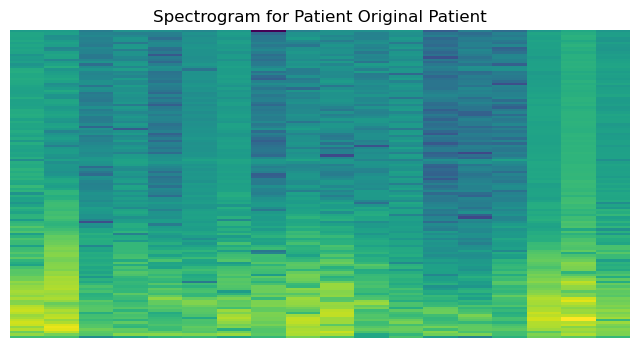

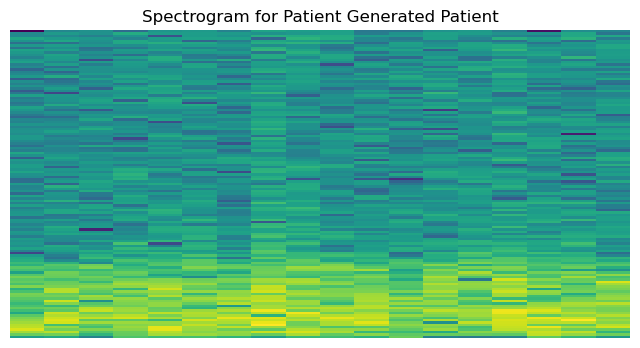

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_spectrogram(patient_data, patient_id, fs=178):
    """
    Plot the spectrogram of a combined EEG signal from 23 records of a patient.
    
    Args:
        patient_data (numpy array): Combined EEG data for a patient (23 records).
        patient_id (int): Patient ID or index.
        fs (int): Sampling frequency (default=178 Hz).
    """
    # Compute the spectrogram
    f, t, Sxx = spectrogram(patient_data, fs)
    
    # Plot the spectrogram
    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), cmap='viridis')
    plt.axis('off')  # Hide axes for aesthetic reasons
    plt.title(f"Spectrogram for Patient {patient_id}")
    
    # Show the plot
    plt.show()

def combine_patient_records(patient_records):
    """
    Combine 23 records of a single patient into a single continuous signal.
    
    Args:
        patient_records (numpy array): Array of shape (23, 178), where each row is a 1-second record.
    
    Returns:
        numpy array: Combined signal of shape (23*178,).
    """
    return patient_records.flatten()

# Example: Plot spectrograms for one original patient and one generated patient
# Plot the first patient from the original data
original_patient_data = X[0:23]  # Extract first 23 records for the original patient
combined_original_patient_data = combine_patient_records(original_patient_data)

# Plot the first generated patient data (assuming X_syn is your generated dataset)
generated_patient_data = X_syn[0:23]  # Extract first 23 records from generated data
combined_generated_patient_data = combine_patient_records(generated_patient_data)

# Plot spectrogram for the original patient
plot_spectrogram(combined_original_patient_data, patient_id="Original Patient")

# Plot spectrogram for the generated patient
plot_spectrogram(combined_generated_patient_data, patient_id="Generated Patient")


In [134]:
X_combined = np.concatenate([X_scaled, scaler.transform(X_syn)], axis=0)
# or if you already inverse_transform()ed X_syn, just re-scale:
# X_syn_scaled = scaler.transform(X_syn_original)
# X_combined = np.concatenate([X_scaled, X_syn_scaled], axis=0)

# For labels, if real are y_adj (0..4), and synthetic are also 0..4
y_combined = np.concatenate([y_adj, y_syn])

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, preds_rf))

RF Accuracy: 0.6975


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)
print("LR Accuracy:", accuracy_score(y_test, preds_lr))

LR Accuracy: 0.28625


In [138]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
preds_mlp = mlp.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, preds_mlp))

MLP Accuracy: 0.7029166666666666


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [161]:
# One-hot encode combined labels
from tensorflow.keras.utils import to_categorical
y_combined_onehot = to_categorical(y_combined, num_classes=5)

In [162]:
# Reshape to (samples, timesteps, features)
X_combined_reshaped = X_combined.reshape((X_combined.shape[0], X_combined.shape[1], 1))

In [163]:
from sklearn.model_selection import train_test_split

# First, split into train_val and test (80-20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined_reshaped, y_combined_onehot,
    test_size=0.2,
    stratify=y_combined,
    random_state=42
)

# Then, split train_val into train and validation (87.5-12.5) to maintain overall 70-10-20 split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,  # 0.125 * 0.8 = 0.10 of total data
    stratify=np.argmax(y_train_val, axis=1),
    random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (8400, 178, 1), (8400, 5)
Validation set shape: (1200, 178, 1), (1200, 5)
Testing set shape: (2400, 178, 1), (2400, 5)


In [164]:
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X_combined_reshaped.shape[0], "Mismatch in total samples after splitting."
assert X_train.shape[1:] == (178, 1), "Incorrect input shape for training data."
assert X_val.shape[1:] == (178, 1), "Incorrect input shape for validation data."
assert X_test.shape[1:] == (178, 1), "Incorrect input shape for testing data."

print("All data splits have correct shapes.")

All data splits have correct shapes.


In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model_correct(input_shape, num_classes):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    model.add(Dropout(0.3))
    
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (178, 1)
num_classes = 5

# Build the model
lstm_model = build_lstm_model_correct(input_shape, num_classes)

# Display model summary
lstm_model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 178, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 178, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,453 (470.52 KB)

 Trainable params: 120,453 (470.52 KB)

 Non-trainable params: 0 (0.00 B)

In [174]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping to halt training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


callbacks = [early_stop]

In [175]:
# Train the LSTM model
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,  # Set a high number; Early Stopping will halt training
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 245ms/step - accuracy: 0.3402 - loss: 1.3873 - val_accuracy: 0.3917 - val_loss: 1.1842
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.3851 - loss: 1.2169 - val_accuracy: 0.4125 - val_loss: 1.1993
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.4149 - loss: 1.1783 - val_accuracy: 0.4175 - val_loss: 1.1678
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.4044 - loss: 1.2090 - val_accuracy: 0.4275 - val_loss: 1.2051
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.4092 - loss: 1.1860 - val_accuracy: 0.4542 - val_loss: 1.1571
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.4246 - loss: 1.1966 - val_accuracy: 0.4192 - val_loss: 1.2035
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.4454 - loss: 1.1780 - val_accuracy: 0.3825 - val_loss: 1.2744
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - accuracy: 0.3878 -

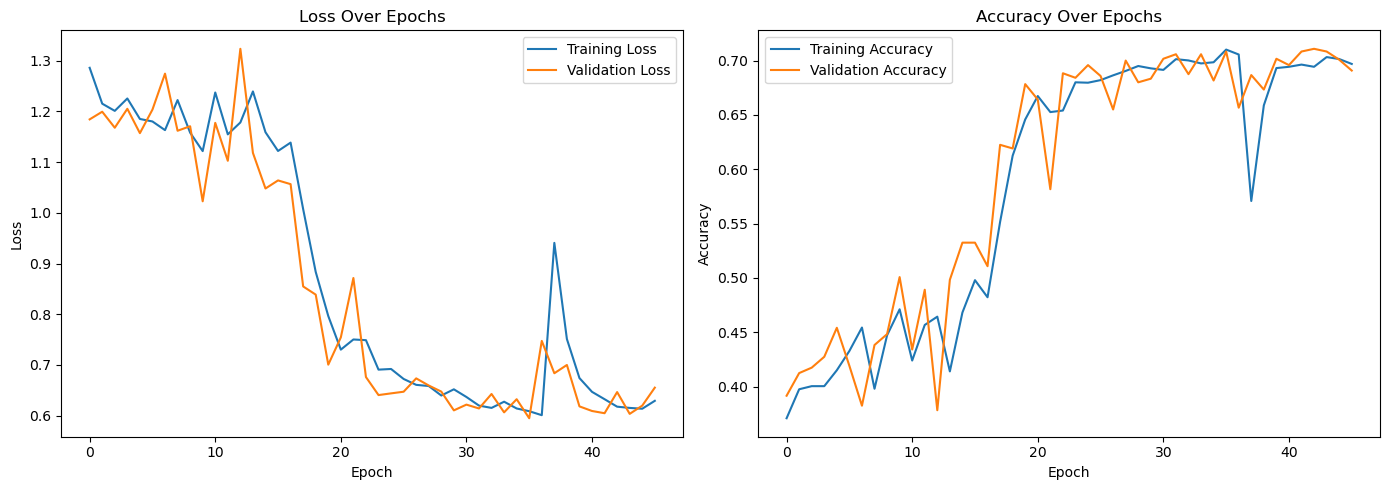

In [176]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [177]:
# Predict probabilities
y_pred_probs = lstm_model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


Classification Report:
              precision    recall  f1-score   support

           0     0.9612    0.9812    0.9711       480
           1     0.5552    0.3771    0.4491       480
           2     0.5263    0.6250    0.5714       480
           3     0.8911    0.6646    0.7613       480
           4     0.6372    0.8708    0.7359       480

    accuracy                         0.7037      2400
   macro avg     0.7142    0.7037    0.6978      2400
weighted avg     0.7142    0.7037    0.6978      2400



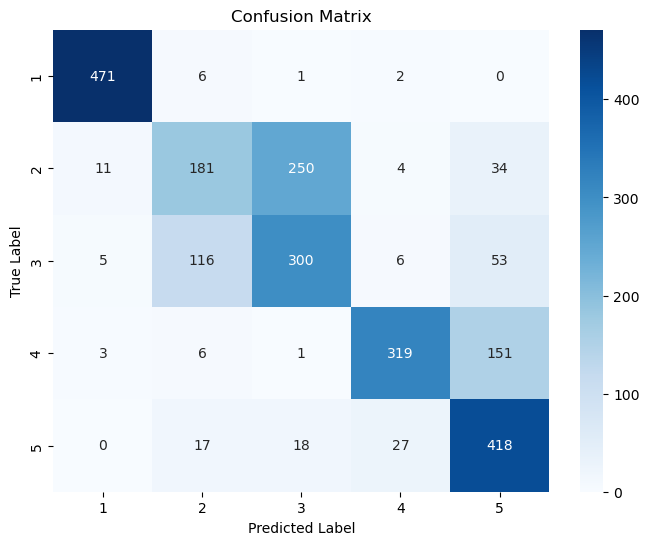

In [178]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5], 
            yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [179]:
# Evaluate the best model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6134
Test Accuracy: 0.7038


In [180]:
import numpy as np

# Original labels: {0, 1, 2, 3, 4} where 0 corresponds to seizure (originally 1)
# and 1-4 correspond to non-seizure (originally 2-5)

# Convert to binary labels: 1 for seizure, 0 for non-seizure
y_binary = np.where(y_combined == 0, 1, 0)  # Assuming '0' is seizure after adjustment

In [181]:
from tensorflow.keras.utils import to_categorical

# One-hot encode binary labels
y_binary_onehot = to_categorical(y_binary, num_classes=2)

print("Binary labels one-hot encoded.")
print(y_binary_onehot[:5])  # Display first 5 one-hot encoded labels

Binary labels one-hot encoded.
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [182]:
# Reshape the data for LSTM: (samples, timesteps, features)
X_combined_reshaped = X_combined.reshape((X_combined.shape[0], X_combined.shape[1], 1))

print(f"Reshaped data shape: {X_combined_reshaped.shape}")  # Expected: (11500, 178, 1)

Reshaped data shape: (12000, 178, 1)


In [183]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and test (20%) sets with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined_reshaped, y_binary_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print(f"Training+Validation set shape: {X_train_val.shape}, {y_train_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Further split Training+Validation into Training (87.5%) and Validation (12.5%)
# 87.5% of 80% = 70% of total data; 12.5% of 80% = 10% of total data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,  # 12.5% of Training+Validation
    random_state=42,
    stratify=np.argmax(y_train_val, axis=1)  # Stratify based on class labels
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

Training+Validation set shape: (9600, 178, 1), (9600, 2)
Testing set shape: (2400, 178, 1), (2400, 2)
Training set shape: (8400, 178, 1), (8400, 2)
Validation set shape: (1200, 178, 1), (1200, 2)


In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_correct_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    
    # Second LSTM layer
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.5))
    
    # Third LSTM layer
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.5))
    
    # Fourth LSTM layer
    model.add(LSTM(64, activation='tanh'))
    model.add(Dropout(0.5))
    
    # Dense layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (178, 1)
num_classes = 2

# Build the model
model_correct = build_correct_lstm_model(input_shape, num_classes)

# Display model summary
model_correct.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 178, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 178, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 178, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 178, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 178, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 178, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,866 (1.09 MB)

 Trainable params: 284,866 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,               
    restore_best_weights=True,
    verbose=1
)

In [191]:
# Train the model
history_correct = model_correct.fit(
    X_train, y_train,
    epochs=50,               
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 75s 545ms/step - accuracy: 0.8817 - loss: 0.3639 - val_accuracy: 0.9592 - val_loss: 0.1201
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 69s 521ms/step - accuracy: 0.9564 - loss: 0.1419 - val_accuracy: 0.9483 - val_loss: 0.2074
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 537ms/step - accuracy: 0.8601 - loss: 0.3495 - val_accuracy: 0.8000 - val_loss: 0.3573
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 535ms/step - accuracy: 0.8069 - loss: 0.3996 - val_accuracy: 0.8700 - val_loss: 0.4005
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 70s 532ms/step - accuracy: 0.8687 - loss: 0.4152 - val_accuracy: 0.8700 - val_loss: 0.3883
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 534ms/step - accuracy: 0.8709 - loss: 0.3973 - val_accuracy: 0.8700 - val_loss: 0.3871
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 70s 529ms/step - accuracy: 0.8743 - loss: 0.3954 - val_accuracy: 0.8700 - val_loss: 0.3842
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 534ms/step - accuracy: 0.8668 - loss: 0

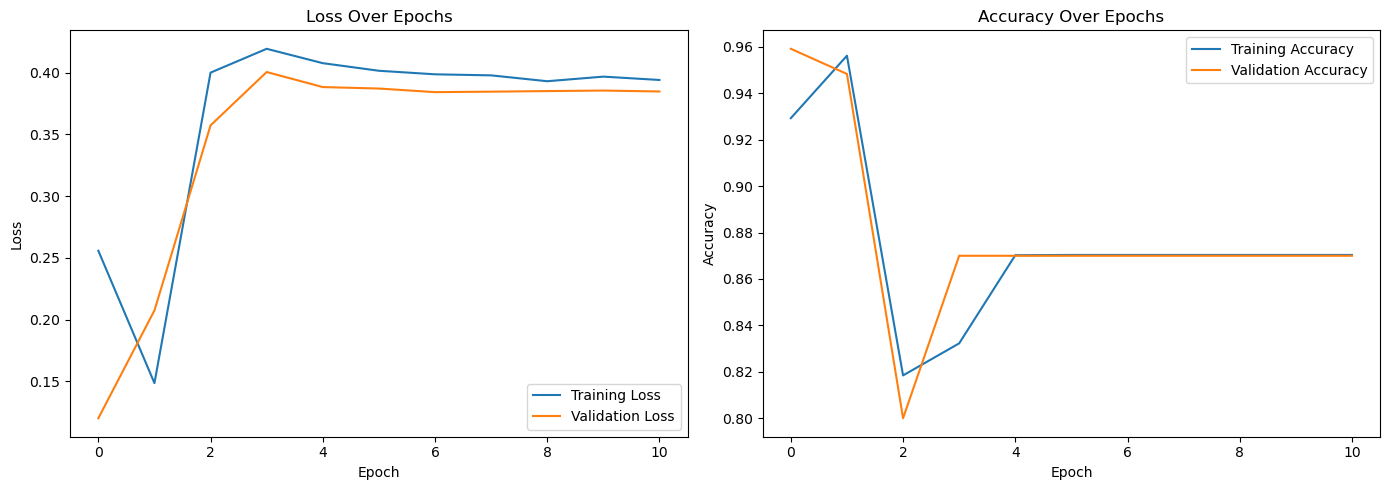

Test Loss: 0.1230
Test Accuracy: 0.9613
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step
Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.99      0.96      0.98      1920
     Seizure       0.86      0.96      0.91       480

    accuracy                           0.96      2400
   macro avg       0.93      0.96      0.94      2400
weighted avg       0.96      0.96      0.96      2400



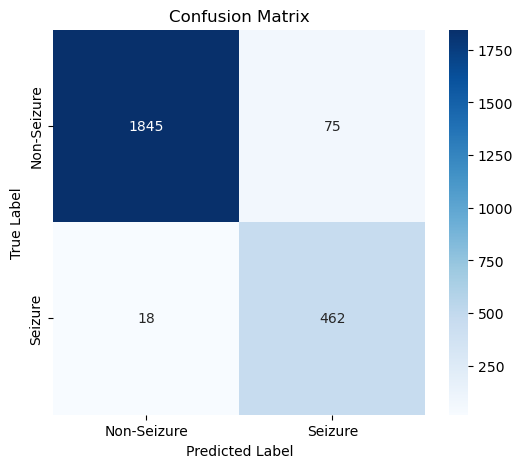

In [192]:
def plot_history(history):
    # Plot Loss
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history_correct)

# Evaluate the model on the test set
test_loss, test_accuracy = model_correct.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_probs = model_correct.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Seizure', 'Seizure']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Seizure', 'Seizure'], 
            yticklabels=['Non-Seizure', 'Seizure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()